In [1]:
%pip install -U -q transformers[torch] evaluate timm albumentations accelerate huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.1 MB/s eta 0:00:00


In [2]:
import json
import torch
import datasets
import requests
import evaluate
import numpy as np
import huggingface_hub
from PIL import Image
import albumentations as A
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Any
from dataclasses import dataclass
from datasets import load_dataset, load_from_disk
import os
import matplotlib.patches as mpatches
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
from transformers import (
    MaskFormerImageProcessor,
    AutoImageProcessor,
    MaskFormerForInstanceSegmentation,
)
from transformers import MaskFormerConfig

torch.manual_seed(42)

In [3]:
# For Can RAT ontology

names= ["CC Clyr Can", "TT Temp Tar", "RAT"]

categories = {
    "CC Clyr Can": 0,  # No need for 'unlabeled' at index 0
    "TT Temp Tar": 1,
    "RAT": 2
}

id2label = {0: "CC Clyr Can", 1: "TT Temp Tar", 2: "RAT"}
label2id = {v: k for k, v in id2label.items()}

print(id2label)

{0: 'CC Clyr Can', 1: 'TT Temp Tar', 2: 'RAT'}


In [ ]:
# Pull datasets from local directories for images and dataset
import os
local_image_dir = r'//content//data//Training_Data//Jan_2026//Can_and_RAT//images'
local_dataset_dir = r'//content//data//Training_Data//Jan_2026//Can_and_RAT'

hf_dataset = load_from_disk(os.path.join(local_dataset_dir, "hf_mask2former_can_rat_dataset"))
train_ds = hf_dataset['train']
val_ds = hf_dataset['validation']

FileNotFoundError: Directory //content//data//Training_Data//Jan_2026//Can_and_RAT/hf_mask2former_can_rat_dataset not found

In [4]:
# Pull data from google drive if stored there
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset from Drive to local runtime
import shutil
import os

# Source (Google Drive)
drive_dataset_dir = '/content/drive/MyDrive/Training_Data/Jan_2026/Can_and_RAT'

# Destination (local runtime - fast!)
local_dataset_dir = '/content/Training_Data/Jan_2026/Can_and_RAT'

# Copy to local
print("Copying dataset from Google Drive to local runtime...")
shutil.copytree(drive_dataset_dir, local_dataset_dir)
print("✓ Copy complete!")

# Now load from LOCAL path (fast)
hf_dataset = load_from_disk(os.path.join(local_dataset_dir, "hf_mask2former_can_rat_dataset"))
train_ds = hf_dataset['train']
val_ds = hf_dataset['validation']

Mounted at /content/drive
Copying dataset from Google Drive to local runtime...
✓ Copy complete!


In [10]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'image_id': 'cmkvm2ofu02ug0788yg7dqftf',
 'segments_info': [{'category_id': 1,
   'id': '1f993b0f-ffcd-4b08-9f60-8993963a6e58',
   'iscrowd': 0},
  {'category_id': 2,
   'id': '46f6502f-0197-4c6c-af23-781a770f2fcf',
   'iscrowd': 0}],
 'annotations': [{'category_id': 1,
   'image_id': 'cmkvm2ofu02ug0788yg7dqftf',
   'segmentation': [[[142.958, 82.73],
     [220.393, 54.933],
     [391.148, 52.947],
     [439.462, 68.831],
     [442.771, 360.703],
     [401.737, 407.032],
     [242.896, 422.254],
     [160.165, 370.631],
     [142.958, 82.73]]]},
  {'category_id': 2,
   'image_id': 'cmkvm2ofu02ug0788yg7dqftf',
   'segmentation': [[[332.166, 222.746],
     [334.666, 256.246],
     [326.666, 261.246],
     [291.166, 262.246],
     [293.166, 222.746],
     [332.166, 222.746]]]}]}

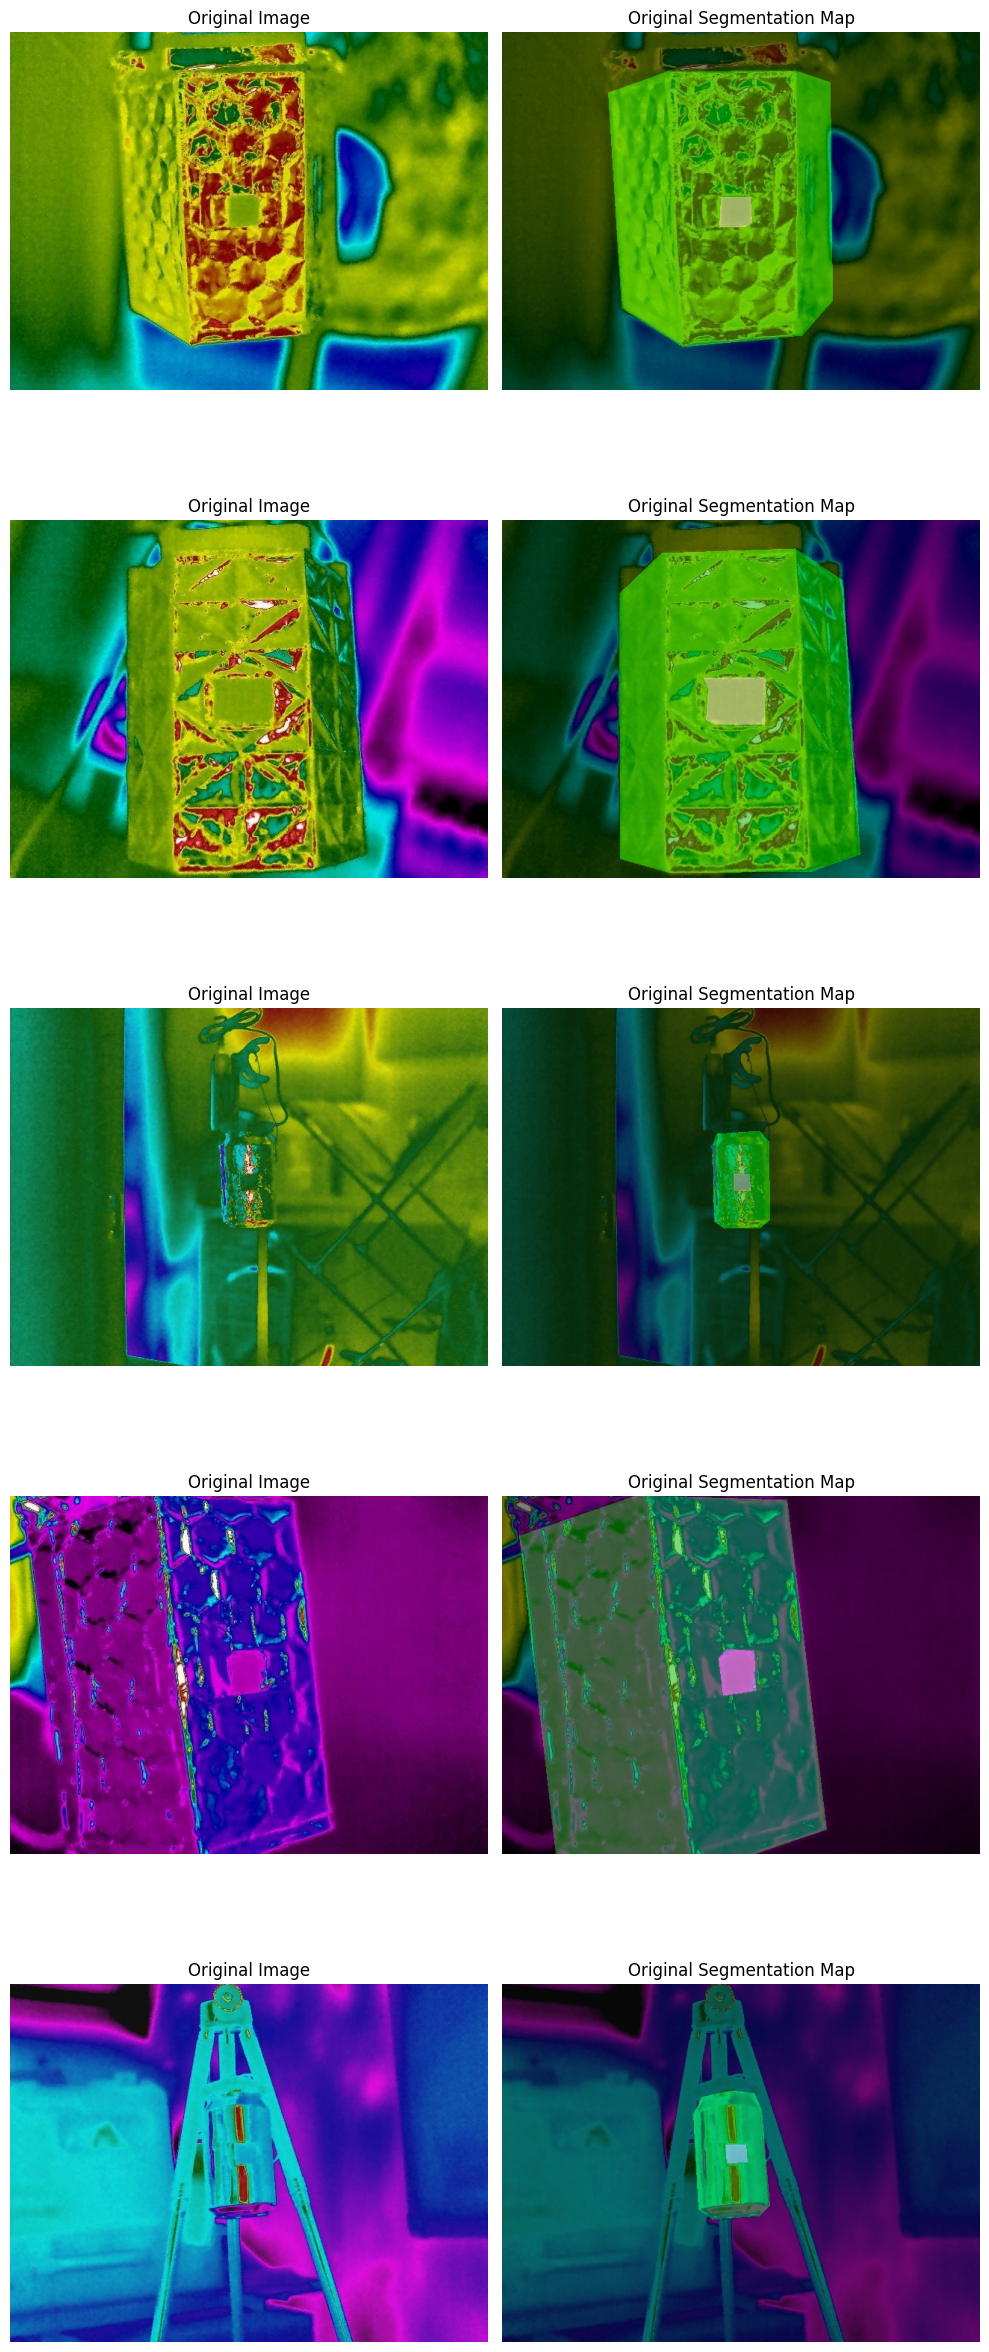

In [13]:
import albumentations as A
from dataclasses import dataclass
import numpy as np
import datasets
from typing import Tuple, Any
from torch.utils.data import Dataset # Explicitly import Dataset
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw # Import Image and ImageDraw

# Redefine ade_mean and ade_std as they are used in train_transform (from cell 74779189)
ade_mean = np.array([123.675, 116.280, 103.530]) / 255
ade_std = np.array([58.395, 57.120, 57.375]) / 255

# Redefine train_transform (from cell 74779189)
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)

# Redefine SegmentationDataInput (from cell 74779189)
@dataclass
class SegmentationDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_segmentation_map: np.ndarray
    transformed_segmentation_map: np.ndarray

# Redefine SemanticSegmentationDataset (from cell 74779189)
class SemanticSegmentationDataset(Dataset):
    def __init__(self, dataset: datasets.Dataset, transform: Any, id2label: dict) -> None: # Added id2label
        """
        Dataset for Semantic Segmentation.
        ----
        Args:
          - dataset: A dataset containing images and segmentation maps.
          - transform: A transformation function to apply to the images and segmentation maps.
          - id2label: Dictionary mapping class ids to their corresponding labels, needed for mask creation.
        """
        self.dataset = dataset
        self.transform = transform
        self.id2label = id2label # Store id2label

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> SegmentationDataInput: # Changed return type hint
        sample = self.dataset[idx]
        original_pil_image = sample["image"]
        original_image = np.array(original_pil_image.convert("RGB")) # Ensure RGB

        image_width, image_height = original_pil_image.size
        original_segmentation_map = np.zeros((image_height, image_width), dtype=np.int64)

        for ann in sample["annotations"]:
            category_id = ann['category_id']
            # Make sure the category_id is one of the expected ones
            if category_id not in self.id2label:
                continue

            segmentations = ann['segmentation']
            for seg in segmentations:
                polygon_coords = []
                for point in seg:
                    polygon_coords.extend(point)

                temp_mask_pil = Image.new('L', (image_width, image_height), 0) # 'L' mode for single channel
                ImageDraw.Draw(temp_mask_pil).polygon(polygon_coords, fill=category_id) # Fill with category_id

                # Convert the drawn mask to a numpy array
                temp_mask_np = np.array(temp_mask_pil, dtype=np.int64)

                # Combine this object's mask with the main segmentation map.
                # Use np.maximum to ensure that if objects overlap, the one with a higher category_id
                # (or simply the last one drawn) takes precedence. This is a common strategy.
                original_segmentation_map = np.maximum(original_segmentation_map, temp_mask_np)

        transformed = self.transform(
            image=original_image, mask=original_segmentation_map
        )
        transformed_image = transformed["image"].transpose(
            2, 0, 1
        )  # Transpose to channel-first format
        transformed_segmentation_map = transformed["mask"]

        return SegmentationDataInput(
            original_image=original_image,
            transformed_image=transformed_image,
            original_segmentation_map=original_segmentation_map,
            transformed_segmentation_map=transformed_segmentation_map,
        )

# Redefine train_dataset (from cell c924f65d, assuming train_ds is available from previously executed cell 1ee1102a)
# Ensure id2label is passed here
train_dataset = SemanticSegmentationDataset(train_ds, transform=train_transform, id2label=id2label)
val_dataset = SemanticSegmentationDataset(val_ds, transform=train_transform, id2label=id2label)
test_dataset = SemanticSegmentationDataset(val_ds, transform=train_transform, id2label=id2label)

# Original visualization code
n = 5

if n > len(train_dataset):
    raise ValueError("n is larger than the dataset size")

fig, axs = plt.subplots(n, 2, figsize=(10, 5 * n))

for i in range(n):
    sample_data = train_dataset[i] # Get SegmentationDataInput object
    image = np.array(sample_data.original_image)
    label = np.array(sample_data.original_segmentation_map)

    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(image)
    # Assuming 'names' is defined and accessible for normalization in visualization
    axs[i, 1].imshow(label / len(names), cmap="nipy_spectral", alpha=0.5)
    axs[i, 1].set_title("Original Segmentation Map")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
preprocessor = MaskFormerImageProcessor(
    ignore_index=255, #this was originally set to zero which meant background was ignored!
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)
ade_mean = np.array([123.675, 116.280, 103.530]) / 255
ade_std = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),  # Resize the image to have the smallest side be 512 while maintaining aspect ratio.
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(width=512, height=512),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)


@dataclass
class SegmentationDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_segmentation_map: np.ndarray
    transformed_segmentation_map: np.ndarray


class SemanticSegmentationDataset(Dataset):
    def __init__(self, dataset: datasets.Dataset, transform: Any) -> None:
        """
        Dataset for Semantic Segmentation.
        ----
        Args:
          - dataset: A dataset containing images and segmentation maps.
          - transform: A transformation function to apply to the images and segmentation maps.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        sample = self.dataset[idx]
        original_image = np.array(sample["pixel_values"])
        original_segmentation_map = np.array(sample["label"])

        transformed = self.transform(
            image=original_image, mask=original_segmentation_map
        )
        transformed_image = transformed["image"].transpose(
            2, 0, 1
        )  # Transpose to channel-first format
        transformed_segmentation_map = transformed["mask"]

        return SegmentationDataInput(
            original_image=original_image,
            transformed_image=transformed_image,
            original_segmentation_map=original_segmentation_map,
            transformed_segmentation_map=transformed_segmentation_map,
        )


def collate_fn(batch: SegmentationDataInput) -> dict:
    original_images = [sample.original_image for sample in batch]
    transformed_images = [sample.transformed_image for sample in batch]
    original_segmentation_maps = [sample.original_segmentation_map for sample in batch]
    transformed_segmentation_maps = [
        sample.transformed_segmentation_map for sample in batch
    ]

    preprocessed_batch = preprocessor(
        transformed_images,
        segmentation_maps=transformed_segmentation_maps,
        return_tensors="pt",
    )

    preprocessed_batch["original_images"] = original_images
    preprocessed_batch["original_segmentation_maps"] = original_segmentation_maps

    return preprocessed_batch

In [12]:
#train_dataset = SemanticSegmentationDataset(train_ds, transform=train_transform)
#val_dataset = SemanticSegmentationDataset(val_ds, transform=train_transform)
#test_dataset = SemanticSegmentationDataset(val_ds, transform=test_transform)#Need a separate test set eventually

# Prepare Dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn
)

TypeError: SemanticSegmentationDataset.__init__() missing 1 required positional argument: 'id2label'

In [ ]:
# Sanity check 1 - spatial dimensions
sample = next(iter(train_dataloader))
print(
    {
        key: value[0].shape if isinstance(value, list) else value.shape
        for key, value in sample.items()
    }
)

In [ ]:
# Sanity check 2 - denormalization and visualization
def denormalize_image(image, mean, std):
    """
    Denormalizes a normalized image.
    ----
    Args:
     - image (numpy.ndarray): The normalized image.
     - mean (list or numpy.ndarray): The mean used for normalization.
     - std (list or numpy.ndarray): The standard deviation used for normalization.

    """
    unnormalized_image = (image * std[:, None, None]) + mean[:, None, None]
    unnormalized_image = (unnormalized_image * 255).numpy().astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return unnormalized_image


denormalized_image = denormalize_image(sample["pixel_values"][0], ade_mean, ade_std)
pil_image = Image.fromarray(denormalized_image)
pil_image

In [ ]:
# Sanity check 3 - mask labels consistent to class labels
labels = [id2label[label] for label in sample["class_labels"][0].tolist()]
print(labels)

In [ ]:
# Sanity check 4 - mask visualization
def visualize_mask(sample, labels, label_name):
    print(f"Category: {label_name}")
    idx = labels.index(label_name)

    visual_mask = (sample["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)


In [ ]:
# Sanity check 5 - visualize_mask
visualize_mask(sample, labels, labels[0])

In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

#output_dir = r'/content/drive/My Drive/AI Models/Mask2Former'
#model_iteration = os.path.join(output_dir,'27March_3')
#processor = AutoImageProcessor.from_pretrained(model_iteration)
#model = MaskFormerForInstanceSegmentation.from_pretrained(
 #   model_iteration, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
#)
#model = Mask2FormerForUniversalSegmentation.from_pretrained(
#    model_iteration, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
#)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-coco-instance")

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-ade-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
   "facebook/mask2former-swin-base-ade-semantic", id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

In [ ]:
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-coco", id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

In [ ]:
model.model.pixel_level_module.encoder.encoder.layers[4]

In [ ]:
# freeze the backbone and pixel decoder
# pixel level module contains both the backbone and the pixel decoder
for param in model.model.pixel_level_module.parameters():
    param.requires_grad = False

# Confirm that the parameters are correctly frozen
for name, param in model.model.pixel_level_module.named_parameters():
    assert not param.requires_grad

In [ ]:
def unfreeze_gradually(model, num_backbone_stages_to_unfreeze=2):
    """
    Unfreezes the last few blocks of the backbone and pixel decoder gradually.

    Args:
        model: The MaskFormerForInstanceSegmentation model.
        num_backbone_stages_to_unfreeze: Number of backbone stages to unfreeze (from the end).
        num_pixel_decoder_layers_to_unfreeze: Number of pixel decoder layers to unfreeze (from the end).
    """

    # 1. Access the Backbone and Pixel Decoder
    backbone = model.model.pixel_level_module.encoder.model.encoder  # Access encoder layers within backbone
    pixel_decoder = model.model.pixel_level_module.decoder  # Access decoder

    # 2. Unfreeze Backbone Stages
    for i in range(len(backbone.layers) - num_backbone_stages_to_unfreeze, len(backbone.layers)):
        for param in backbone.layers[i].parameters():
            param.requires_grad = True

    # 3. Unfreeze Pixel Decoder Layers
    # The pixel decoder in MaskFormer is a single module, not a stack of layers.
    # So, we directly unfreeze its parameters.
    for param in pixel_decoder.parameters():  # Corrected line
        param.requires_grad = True

    # 4. Verify Unfreezing (Optional)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Unfrozen: {name}")

In [ ]:
unfreeze_gradually(model, num_backbone_stages_to_unfreeze=4)

In [ ]:
#unfreeze pixel decoder
for param in pixel_decoder.parameters():  # Corrected line
    param.requires_grad = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = evaluate.load("mean_iou")


def evaluate_model(
    model: MaskFormerForInstanceSegmentation,
    dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: Any,
    id2label: dict,
    max_batches=None,
):
    """
    Evaluates the given model using the specified dataloader and computes the mean Intersection over Union (IoU).
    ----
    Args:
      - model (MaskFormerForInstanceSegmentation): The trained model to be evaluated.
      - dataloader (DataLoader): DataLoader containing the dataset for evaluation.
      - preprocessor (AutoImageProcessor): The preprocessor used for post-processing the model outputs.
      - metric (Any): Metric instance used for calculating IoU.
      - id2label (dict): Dictionary mapping class ids to their corresponding labels.
      - max_batches (int, optional): Maximum number of batches to evaluate. If None, evaluates on the entire validation dataset.

    Returns:
    float: The mean IoU calculated over the specified number of batches.
    """
    model.eval()
    running_iou = 0
    num_batches = 0
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloader)):
            if max_batches and idx >= max_batches:
                break

            pixel_values = batch["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            original_images = batch["original_images"]
            target_sizes = [
                (image.shape[0], image.shape[1]) for image in original_images
            ]

            predicted_segmentation_maps = (
                preprocessor.post_process_semantic_segmentation(
                    outputs, target_sizes=target_sizes
                )
            )

            ground_truth_segmentation_maps = batch["original_segmentation_maps"]
            metric.add_batch(
                references=ground_truth_segmentation_maps,
                predictions=predicted_segmentation_maps,
            )

            running_iou += metric.compute(num_labels=len(id2label), ignore_index=0)[
                "mean_iou"
            ]
            num_batches += 1

    mean_iou = running_iou / num_batches
    return mean_iou


def train_model(
    model: MaskFormerForInstanceSegmentation,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: AutoImageProcessor,
    id2label: dict,
    num_epochs=20,
    learning_rate=5e-5,
    log_interval=100,
):
    """
    Trains the MaskFormer model for semantic segmentation over a specified number of epochs and evaluates it on a validation set.
    ----
    Args:
      - model (MaskFormerForInstanceSegmentation): The model to be trained.
      - train_dataloader (DataLoader): DataLoader for the training data.
      - val_dataloader (DataLoader): DataLoader for the validation data.
      - preprocessor (AutoImageProcessor): The preprocessor used for preparing the data.
      - metric (Any): Metric instance used for calculating performance metrics.
      - id2label (dict): Dictionary mapping class IDs to their corresponding labels.
      - num_epochs (int): Number of epochs to train the model.
      - learning_rate (float): Learning rate for the optimizer.
      - log_interval (int): Interval (in number of batches) at which to log training progress.

    """
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch+1}/{num_epochs}")
        model.train()

        running_loss = 0.0
        num_samples = 0

        for idx, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()

            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            loss = outputs.loss
            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size

            if idx % log_interval == 0 and idx > 0:
                print(f"Iteration {idx} - loss: {running_loss/num_samples}")

            optimizer.step()
        val_mean_iou = evaluate_model(
            model, val_dataloader, preprocessor, metric, id2label, max_batches=6
        )
        print(f"Validation Mean IoU: {val_mean_iou}")

In [ ]:
train_model(
    model,
    train_dataloader,
    val_dataloader,
    preprocessor,
    metric,
    id2label,
    num_epochs=1,
    log_interval=100,
)

In [ ]:
from tqdm.auto import tqdm

def train_model_with_schedule(model, train_dataloader, val_dataloader, preprocessor, metric, id2label, train_schedule):
    output_dir = r'/content/drive/My Drive/AI Models/Mask2Former_base'  # Or your preferred output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    backbone = model.model.pixel_level_module.encoder.encoder  # Access encoder layers within backbone
    pixel_decoder = model.model.pixel_level_module.decoder  # Access decoder

    #starting point is frozen pixel_decoder and backbone
    for param in model.model.pixel_level_module.parameters():
        param.requires_grad = False

    # Confirm that the parameters are correctly frozen
    for name, param in model.model.pixel_level_module.named_parameters():
        assert not param.requires_grad

    #for phase_index, phase in enumerate(train_schedule):
    for phase_index, phase in enumerate(train_schedule[2:], start=2):
        learning_rate = phase["learning_rate"]
        epochs = phase["epochs"]

        # Freeze/Unfreeze Pixel Decoder
        for param in pixel_decoder.parameters():
            param.requires_grad = not phase["pixel_decoder_freeze"]

        # Freeze/Unfreeze Backbone Layers (if needed)
        num_backbone_unfreeze = phase["num_backbone_unfreeze"]

        if num_backbone_unfreeze > 0:  # Only unfreeze if num_backbone_freeze is greater than 0
            for i in range(len(backbone.layers) - num_backbone_unfreeze, len(backbone.layers)):
                for param in backbone.layers[i].parameters():
                    param.requires_grad = True

        # Train
        train_model(
            model,
            train_dataloader,
            val_dataloader,
            preprocessor,
            metric,
            id2label,
            num_epochs=epochs,
            learning_rate=learning_rate,
            log_interval=100,
        )

        # Save Model
        model_iteration = os.path.join(output_dir, f'phase_{phase_index + 1}')
        if not os.path.exists(model_iteration):
            os.makedirs(model_iteration)
        model.save_pretrained(model_iteration)
        processor.save_pretrained(model_iteration)

        # Test Mean IoU
        test_mean_iou = evaluate_model(model, test_dataloader, preprocessor, metric, id2label)
        print(f"Test Mean IoU (Phase {phase_index + 1}): {test_mean_iou}")

In [ ]:
train_schedule = [
    {"learning_rate": 5e-5, "epochs": 15, "pixel_decoder_freeze": True, "num_backbone_unfreeze": 0},  # Phase 1
    {"learning_rate": 1e-5, "epochs": 10, "pixel_decoder_freeze": False, "num_backbone_unfreeze": 0},  # Phase 2
    {"learning_rate": 5e-6, "epochs": 5, "pixel_decoder_freeze": False, "num_backbone_unfreeze": 1},  # Phase 3
    {"learning_rate": 5e-6, "epochs": 5, "pixel_decoder_freeze": False, "num_backbone_unfreeze": 2},  # Phase 4
    {"learning_rate": 5e-6, "epochs": 5, "pixel_decoder_freeze": False, "num_backbone_unfreeze": 3},  # Phase 5
    {"learning_rate": 5e-6, "epochs": 5, "pixel_decoder_freeze": False, "num_backbone_unfreeze": 4},  # Phase 6
    # Add more phases as needed...
]
train_model_with_schedule(model, train_dataloader, val_dataloader, preprocessor, metric, id2label, train_schedule)